In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [3]:
from exceptions import DataPipelineError, FeatureEngineeringError

from data.data_pipeline import DataPipeline

In [4]:
from typing import Dict
import pandas as pd
from tabulate import tabulate
from dataclasses import dataclass
from datetime import datetime

@dataclass
class DataStatus:
    raw_count: int
    processed_count: int
    universe_count: int
    raw_symbols: list
    processed_symbols: list
    universe_symbols: list
    columns: list

def format_data_status(pipeline) -> str:
    """
    Format the data status output in a readable table format.
    
    Args:
        pipeline: DataPipeline instance
        
    Returns:
        Formatted string with data status information
    """
    status = pipeline.check_data_status()
    
    # Create DataStatus object for easier handling
    data_status = DataStatus(
        raw_count=status['raw_data']['count'],
        processed_count=status['processed_data']['count'],
        universe_count=status['universe']['count'],
        raw_symbols=status['raw_data']['symbols'],
        processed_symbols=status['processed_data']['symbols'],
        universe_symbols=status['universe']['symbols'],
        columns=status['raw_data']['sample_columns'] if status['raw_data']['count'] > 0 else []
    )
    
    # Create summary table
    summary_data = [
        ["Raw Data", data_status.raw_count, ", ".join(data_status.raw_symbols[:3]) + ("..." if len(data_status.raw_symbols) > 3 else "")],
        ["Processed Data", data_status.processed_count, ", ".join(data_status.processed_symbols[:3]) + ("..." if len(data_status.processed_symbols) > 3 else "")],
        ["Universe", data_status.universe_count, ", ".join(data_status.universe_symbols[:3]) + ("..." if len(data_status.universe_symbols) > 3 else "")]
    ]
    
    summary_table = tabulate(summary_data, 
                           headers=["Stage", "Count", "Sample Symbols"],
                           tablefmt="grid")
    
    # Create columns table if available
    columns_str = ""
    if data_status.columns:
        columns_table = tabulate([["Available Columns", ", ".join(data_status.columns)]], 
                               tablefmt="grid")
        columns_str = f"\n\nColumns:\n{columns_table}"
    
    return f"Data Pipeline Status:\n{summary_table}{columns_str}"

def format_data_quality(pipeline) -> str:
    """
    Format the data quality metrics in a readable table format.
    
    Args:
        pipeline: DataPipeline instance
        
    Returns:
        Formatted string with data quality information
    """
    quality_metrics = pipeline.validate_data_quality()
    
    # Prepare data for main metrics table
    metrics_data = []
    for symbol, metrics in quality_metrics.items():
        metrics_data.append([
            symbol,
            metrics['data_points'],
            metrics['missing_values'],
            f"{metrics['avg_volume']:,.0f}",
            metrics['zero_volume_days'],
            metrics['start_date'].strftime('%Y-%m-%d'),
            metrics['end_date'].strftime('%Y-%m-%d')
        ])
    
    # Create main metrics table
    metrics_table = tabulate(metrics_data,
                           headers=["Symbol", "Data Points", "Missing Values", 
                                  "Avg Volume", "Zero Volume Days", 
                                  "Start Date", "End Date"],
                           tablefmt="grid")
    
    # Calculate and format summary statistics
    total_data_points = sum(m['data_points'] for m in quality_metrics.values())
    total_missing = sum(m['missing_values'] for m in quality_metrics.values())
    avg_missing = total_missing / len(quality_metrics) if quality_metrics else 0
    
    summary_data = [
        ["Total Symbols", len(quality_metrics)],
        ["Total Data Points", total_data_points],
        ["Average Missing Values", f"{avg_missing:.2f}"],
        ["Date Range", f"{min((m['start_date'] for m in quality_metrics.values())).strftime('%Y-%m-%d')} to "
                      f"{max((m['end_date'] for m in quality_metrics.values())).strftime('%Y-%m-%d')}"]
    ]
    
    summary_table = tabulate(summary_data,
                           headers=["Metric", "Value"],
                           tablefmt="grid")
    
    return f"Data Quality Summary:\n{summary_table}\n\nDetailed Metrics by Symbol:\n{metrics_table}"


In [11]:
# Initialize pipeline
pipeline = DataPipeline(
    start_date='2010-01-01',
    end_date='2023-12-31',
    universe_size=500,
    cache_dir='data/cache',
    price_col='Close'
)

# Fetch data
symbols = [
    'AMZN', 'META', 'NVDA', 'TSLA', 'JPM', 'JNJ', 'WMT', 
    'PG', 'XOM', 'BAC', 'HD', 'COST', 'V', 'DIS'
]
pipeline.fetch_data(symbols)

# Check status after fetch
print("\nStatus after fetch:")
print(format_data_status(pipeline))

# Process data
pipeline.process_data()

# Check quality after processing
print("\nQuality after processing:")
print(format_data_quality(pipeline))

# Create universe
pipeline.create_universe()

print("\nStatus after creating universe:")

X_train, X_test, y_train, y_test = pipeline.get_training_data()

# Check status after creating universe
print(f"\nI got the training data with shapes: {X_train.shape} and {X_test.shape}")

print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

19:47:32 - DataPipeline - INFO - Fetching data for 14 symbols...
19:47:32 - DataPipeline - INFO - Successfully fetched data for 14 symbols

Status after fetch:
Data Pipeline Status:
+----------------+---------+---------------------+
| Stage          |   Count | Sample Symbols      |
+================+=========+=====================+
| Raw Data       |      14 | TSLA, NVDA, META... |
+----------------+---------+---------------------+
| Processed Data |       0 |                     |
+----------------+---------+---------------------+
| Universe       |       0 |                     |
+----------------+---------+---------------------+

Columns:
+-------------------+---------------------------------------------------------+
| Available Columns | Open, High, Low, Close, Volume, Dividends, Stock Splits |
+-------------------+---------------------------------------------------------+
19:47:32 - DataPipeline - INFO - Starting data processing with 14 symbols
19:47:32 - DataPipeline - INFO - Pr

In [12]:
from models.mean_reversion_analyzer import MeanReversionAnalyzer

# Initialize mean reversion analyzer with our existing pipeline
mean_reversion = MeanReversionAnalyzer(
    data_pipeline=pipeline,
    lookback_periods=20,
    z_score_threshold=2.0,
    volume_percentile=0.7,
    max_positions=5
)

# Generate signals and store them
signals = mean_reversion.generate_signals()

# Display initial results
print("Mean Reversion Positions:")
print("-" * 40)
print(f"Long positions ({len(signals.longs)}):", signals.longs)
print(f"Short positions ({len(signals.shorts)}):", signals.shorts)

19:50:07 - DataPipeline - INFO - Filtered universe contains 4 symbols
Mean Reversion Positions:
----------------------------------------
Long positions (0): []
Short positions (0): []


In [19]:
# First, let's check what our universe looks like
print("Current universe:", pipeline.universe)

# Let's examine the filtering process
filtered_universe = mean_reversion.filter_universe()
print("\nFiltered universe:", filtered_universe)

# Let's look at the actual z-scores before thresholding
for symbol in pipeline.universe:
    data = pipeline.processed_data[symbol]
    z_scores = mean_reversion.calculate_z_scores(data)
    print(f"\nZ-scores for {symbol}:")
    print(f"Latest z-score: {z_scores.iloc[-1]:.3f}")

Current universe: ['NVDA', 'BAC', 'TSLA', 'AMZN', 'META', 'WMT', 'JPM', 'XOM', 'V', 'DIS', 'PG', 'JNJ', 'HD', 'COST']

Filtered universe: ['NVDA', 'BAC', 'TSLA', 'AMZN']

Z-scores for NVDA:
Latest z-score: 1.028

Z-scores for BAC:
Latest z-score: 0.918

Z-scores for TSLA:
Latest z-score: 0.170

Z-scores for AMZN:
Latest z-score: 0.619

Z-scores for META:
Latest z-score: 1.057

Z-scores for WMT:
Latest z-score: 1.539

Z-scores for JPM:
Latest z-score: 1.320

Z-scores for XOM:
Latest z-score: -0.535

Z-scores for V:
Latest z-score: 1.074

Z-scores for DIS:
Latest z-score: -1.341

Z-scores for PG:
Latest z-score: 0.044

Z-scores for JNJ:
Latest z-score: 0.474

Z-scores for HD:
Latest z-score: 0.545

Z-scores for COST:
Latest z-score: 0.984


In [20]:
# Example usage
from config.settings import DEFAULT_MODEL_TYPE
from models.model_pipeline import ModelPipeline

# Initialize pipeline
model = ModelPipeline()

# Train model
model.train(X_train, y_train, X_test, y_test)

# Generate predictions
predictions = model.predict(X_test)

# Evaluate model
model.evaluate_model(X_test, y_test)

20:22:17 - DataPipeline - INFO - Initializing model pipeline with catboost model
20:22:59 - DataPipeline - INFO - Model Evaluation Results:
20:22:59 - DataPipeline - INFO - mse: 0.0023
20:22:59 - DataPipeline - INFO - rmse: 0.0475
20:22:59 - DataPipeline - INFO - mae: 0.0331
20:22:59 - DataPipeline - INFO - r2: 0.0009
20:22:59 - DataPipeline - INFO - directional_accuracy: 0.5336
20:22:59 - DataPipeline - INFO - precision: 0.5335
20:22:59 - DataPipeline - INFO - recall: 1.0000


{'mse': 0.0022570872058955507,
 'rmse': 0.04750881187627776,
 'mae': 0.03314557189254731,
 'r2': 0.000917019937664354,
 'directional_accuracy': 0.5335828654605947,
 'precision': 0.533534366226474,
 'recall': 1.0}


Testing Portfolio Strategy
--------------------------------------------------

1. Testing Monthly Metrics Calculation...
Monthly returns shape: (168, 14)
Monthly volumes shape: (168, 14)

Sample of monthly returns:
                             NVDA     BAC    TSLA    AMZN    META     WMT  \
Date                                                                        
2023-08-31 00:00:00-04:00  0.0562 -0.0966 -0.0350  0.0324 -0.0713  0.0208   
2023-09-30 00:00:00-04:00 -0.1186 -0.0450 -0.0305 -0.0789  0.0146 -0.0165   
2023-10-31 00:00:00-04:00 -0.0625 -0.0380 -0.1973  0.0470  0.0035  0.0218   
2023-11-30 00:00:00-05:00  0.1469  0.1668  0.1954  0.0977  0.0859 -0.0472   
2023-12-31 00:00:00-05:00  0.0589  0.1043  0.0350  0.0400  0.0820  0.0163   

                              JPM     XOM       V     DIS      PG     JNJ  \
Date                                                                        
2023-08-31 00:00:00-04:00 -0.0736  0.0453  0.0354 -0.0586 -0.0125 -0.0279   
2023-09-30 00

c:\Users\calvi\Repositories\NivlacSignals\CS470_Project\ml_trading_strategy\strategy\PortfolioStrategy.py:90: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = data['Close'].resample('M').last().pct_change()
c:\Users\calvi\Repositories\NivlacSignals\CS470_Project\ml_trading_strategy\strategy\PortfolioStrategy.py:94: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_volumes = data['Volume'].resample('M').mean()


20:23:24 - DataPipeline - INFO - Filtered universe contains 4 symbols
Number of signals - Longs: 0, Shorts: 0
20:23:24 - DataPipeline - ERROR - Error optimizing portfolio: Insufficient symbols for optimization
Optimization error: Error optimizing portfolio: Insufficient symbols for optimization

3. Testing Portfolio Rebalancing...
20:23:24 - DataPipeline - WARNING - Insufficient positions for balanced portfolio

New portfolio positions:

4. Testing Performance Metrics...

Portfolio metrics:


c:\Users\calvi\Repositories\NivlacSignals\CS470_Project\ml_trading_strategy\strategy\PortfolioStrategy.py:90: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = data['Close'].resample('M').last().pct_change()
c:\Users\calvi\Repositories\NivlacSignals\CS470_Project\ml_trading_strategy\strategy\PortfolioStrategy.py:94: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_volumes = data['Volume'].resample('M').mean()


TypeError: no numeric data to plot

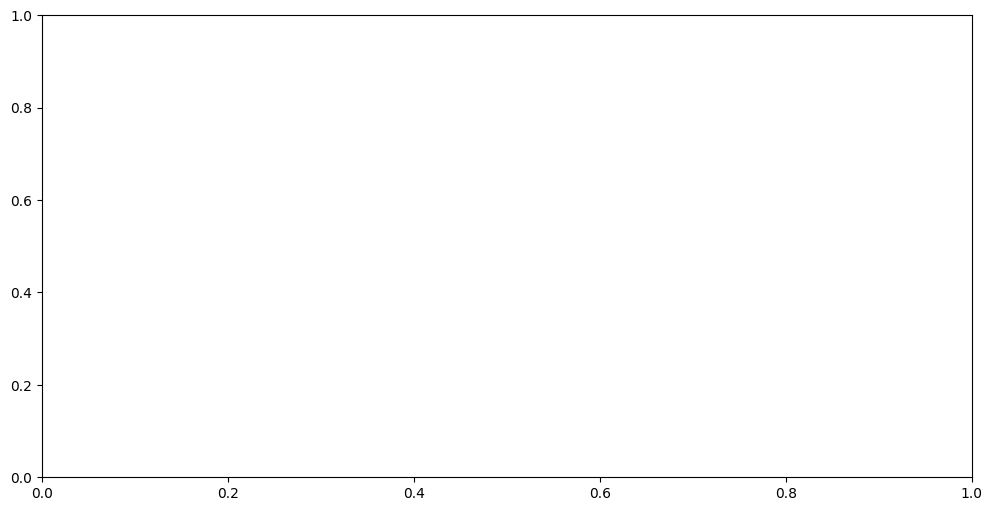

In [21]:
# Add this after your existing code

from strategy.PortfolioStrategy import PortfolioStrategy
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the portfolio strategy
strategy = PortfolioStrategy(
    data_pipeline=pipeline,
    initial_capital=1_000_000
)

print("\nTesting Portfolio Strategy")
print("-" * 50)

# 1. Test monthly metrics calculation
print("\n1. Testing Monthly Metrics Calculation...")
strategy.update_monthly_metrics()
print(f"Monthly returns shape: {strategy.monthly_returns.shape}")
print(f"Monthly volumes shape: {strategy.monthly_volumes.shape}")

# Print sample of monthly returns
print("\nSample of monthly returns:")
print(strategy.monthly_returns.tail().round(4))

# 2. Test portfolio optimization
print("\n2. Testing Portfolio Optimization...")
latest_signals = mean_reversion.generate_signals()
print(f"Number of signals - Longs: {len(latest_signals.longs)}, Shorts: {len(latest_signals.shorts)}")

try:
    optimal_weights = strategy.optimize_portfolio(
        latest_signals,
        strategy.monthly_returns
    )
    print("\nOptimal portfolio weights:")
    for symbol, weight in sorted(optimal_weights.items(), key=lambda x: abs(x[1]), reverse=True):
        print(f"{symbol}: {weight:.4f}")
    
    # Calculate total long and short exposure
    total_long = sum(w for w in optimal_weights.values() if w > 0)
    total_short = sum(w for w in optimal_weights.values() if w < 0)
    print(f"\nTotal long exposure: {total_long:.4f}")
    print(f"Total short exposure: {total_short:.4f}")
    print(f"Net exposure: {total_long + total_short:.4f}")
    print(f"Gross exposure: {total_long - total_short:.4f}")

except Exception as e:
    print(f"Optimization error: {e}")

# 3. Test portfolio rebalancing
print("\n3. Testing Portfolio Rebalancing...")
current_date = pd.Timestamp('2023-12-31')
try:
    new_positions = strategy.rebalance_portfolio(latest_signals, current_date)
    print("\nNew portfolio positions:")
    for symbol, pos in sorted(new_positions.items(), key=lambda x: abs(x[1]), reverse=True):
        print(f"{symbol}: {pos:.4f}")
except Exception as e:
    print(f"Rebalancing error: {e}")

# 4. Test performance metrics
print("\n4. Testing Performance Metrics...")
metrics = strategy.calculate_portfolio_metrics()
print("\nPortfolio metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# 5. Visualize Portfolio Allocation
plt.figure(figsize=(12, 6))
positions = pd.Series(new_positions)
colors = ['green' if x > 0 else 'red' for x in positions.values]
positions.plot(kind='bar', color=colors)
plt.title('Portfolio Positions')
plt.xlabel('Symbols')
plt.ylabel('Position Size')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Visualize Monthly Returns Distribution
plt.figure(figsize=(12, 6))
strategy.monthly_returns.mean().hist(bins=20)
plt.title('Distribution of Monthly Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 7. Print Strategy Settings
print("\n5. Strategy Settings:")
print("-" * 50)
print(f"Rebalance frequency: {strategy.rebalance_days} days")
print(f"Max position size: {strategy.max_position_size:.2%}")
print(f"Min positions per side: {strategy.min_positions}")
print(f"Target leverage: {strategy.target_leverage:.2f}")
print(f"Risk-free rate: {strategy.risk_free_rate:.2%}")

# 8. Risk Analysis
print("\n6. Risk Analysis:")
print("-" * 50)
if len(strategy.monthly_returns) > 0:
    returns_matrix = strategy.monthly_returns.fillna(0)
    correlation_matrix = returns_matrix.corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Asset Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Calculate and print risk metrics
    volatility = returns_matrix.std() * np.sqrt(12)
    print("\nAnnualized Volatility by Asset:")
    print(volatility.sort_values(ascending=False).round(4))

# 9. Position Limits Check
print("\n7. Position Limits Check:")
print("-" * 50)
if new_positions:
    max_position = max(abs(pd.Series(new_positions)))
    print(f"Maximum absolute position size: {max_position:.2%}")
    print(f"Position size limit: {strategy.max_position_size:.2%}")
    print("Position limit check:", "PASSED" if max_position <= strategy.max_position_size else "FAILED")

# Save results to a report
report = pd.DataFrame({
    'Metric': list(metrics.keys()),
    'Value': list(metrics.values())
})

print("\n8. Saving results...")
report.to_csv('strategy_test_results.csv', index=False)
print("Results saved to 'strategy_test_results.csv'")